In [17]:
import sys
sys.path.append('/Users/Sakarias/QuantTrading')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import logging

from core.taa.optimizer import TAAOptimizer, BacktestOptimizer
from core.taa.constraints import load_constraints_from_config
from core.data.collectors.yahoo_collector import YahooCollector

# Enable logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s - %(name)s - %(message)s')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline


## 1. Load OOS Predictions from Walk-Forward Validation

In [18]:
# Load predictions for different horizons (in long format)
data_dir = Path('../../data/taa')

pred_1w_long = pd.read_csv(data_dir / 'oos_predictions_1w.csv')
pred_4w_long = pd.read_csv(data_dir / 'oos_predictions_4w.csv')
pred_12w_long = pd.read_csv(data_dir / 'oos_predictions_12w.csv')

print(f"Raw predictions loaded:")
print(f"  1-week: {pred_1w_long.shape}")
print(f"  4-week: {pred_4w_long.shape}")
print(f"  12-week: {pred_12w_long.shape}")

# Pivot to wide format: rows=dates, columns=tickers, values=predicted returns
pred_1w = pred_1w_long.pivot(index='date', columns='ticker', values='predicted')
pred_4w = pred_4w_long.pivot(index='date', columns='ticker', values='predicted')
pred_12w = pred_12w_long.pivot(index='date', columns='ticker', values='predicted')

# Convert index to datetime
pred_1w.index = pd.to_datetime(pred_1w.index)
pred_4w.index = pd.to_datetime(pred_4w.index)
pred_12w.index = pd.to_datetime(pred_12w.index)

print(f"\nPivoted predictions:")
print(f"  1-week: {pred_1w.shape}")
print(f"  4-week: {pred_4w.shape}")
print(f"  12-week: {pred_12w.shape}")

# Choose horizon for portfolio construction (4-week = monthly rebalancing)
predictions = pred_4w.copy()
print(f"\nUsing 4-week predictions for portfolio optimization")
print(f"Date range: {predictions.index.min()} to {predictions.index.max()}")
print(f"Tickers: {predictions.columns.tolist()}")
predictions.head()


Raw predictions loaded:
  1-week: (13567, 5)
  4-week: (13552, 5)
  12-week: (13512, 5)

Pivoted predictions:
  1-week: (1508, 9)
  4-week: (1506, 9)
  12-week: (1502, 9)

Using 4-week predictions for portfolio optimization
Date range: 2015-01-02 00:00:00 to 2024-12-26 00:00:00
Tickers: ['SPY', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']


ticker,SPY,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,
2015-01-02,-0.014077,-0.006334,-0.030644,-0.004220,-0.004414,-0.001177,0.008246,-0.012096,-0.037877
2015-01-05,-0.025494,-0.017800,-0.027517,-0.016784,-0.011862,-0.013456,-0.016778,-0.013957,-0.037011
2015-01-06,-0.029047,-0.024033,-0.030161,-0.023007,-0.008436,-0.013400,-0.020636,-0.015910,-0.045334
2015-01-07,-0.019341,-0.012361,-0.011399,-0.013321,-0.008858,-0.010805,0.001404,-0.009200,-0.029657
2015-01-08,0.000342,0.007179,-0.001657,0.001207,0.002213,-0.012292,0.009545,-0.003776,-0.028614


## 2. Load Historical Returns for Covariance Estimation

In [19]:
# Fetch historical prices
collector = YahooCollector()
tickers = predictions.columns.tolist()

print(f"Fetching prices for tickers: {tickers}")

# Fetch from 2010 to cover full prediction period
prices = collector.fetch_history(
    tickers=tickers,
    start_date='2010-01-01',
    end_date='2024-12-31'
)

print(f"Raw prices shape: {prices.shape}")
print(f"Price levels: {prices.columns.get_level_values('Price').unique().tolist()}")
print(f"Tickers in prices: {prices.columns.get_level_values('Ticker').unique().tolist()}")

# Extract Close prices - handle MultiIndex properly
if isinstance(prices.columns, pd.MultiIndex):
    # Check which level has tickers
    if 'Ticker' in prices.columns.names:
        close_prices = prices.xs('Close', level='Price', axis=1)
    else:
        # Might be (Price, Ticker) instead of (Ticker, Price)
        try:
            close_prices = prices.xs('Close', level=0, axis=1)
        except:
            close_prices = prices.xs('Close', level=1, axis=1)
else:
    # Not a MultiIndex, assume all columns are tickers
    close_prices = prices

print(f"Close prices shape: {close_prices.shape}")
print(f"Close prices columns: {close_prices.columns.tolist()}")
print(f"Close prices has data: {not close_prices.empty}")
print(f"First few rows:\n{close_prices.head()}")

# Calculate daily returns
returns = close_prices.pct_change().dropna()
print(f"\nReturns shape: {returns.shape}")
print(f"Returns has data: {len(returns) > 0}")
if len(returns) > 0:
    print(f"Date range: {returns.index.min()} to {returns.index.max()}")
    print(f"Returns columns: {returns.columns.tolist()}")
else:
    print("WARNING: Returns DataFrame is empty!")


INFO - core.data.collectors.yahoo_collector - Fetching 1d data for 9 tickers from 2010-01-01 to 2024-12-31


Fetching prices for tickers: ['SPY', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
Raw prices shape: (3773, 45)
Price levels: ['Open', 'High', 'Low', 'Close', 'Volume']
Tickers in prices: ['XLE', 'XLF', 'XLP', 'XLI', 'XLV', 'XLU', 'SPY', 'XLY', 'XLK']
Close prices shape: (3773, 9)
Close prices columns: ['XLE', 'XLF', 'XLP', 'XLI', 'XLV', 'XLU', 'SPY', 'XLY', 'XLK']
Close prices has data: True
First few rows:
Ticker            XLE       XLF        XLP        XLI        XLV       XLU  \
Date                                                                         
2010-01-04  17.381094  8.988359  17.347876  20.981579  24.083450  8.948220   
2010-01-05  17.522957  9.153563  17.354376  21.055668  23.847263  8.841694   
2010-01-06  17.732800  9.171917  17.341372  21.100113  24.091066  8.893517   
2010-01-07  17.706194  9.367718  17.341372  21.329790  24.174875  8.853210   
2010-01-08  17.821457  9.312651  17.282827  21.670584  24.212969  8.844573   

Ticker            SPY        XL

## 3. Load Constraints from Config

In [20]:
# Load optimization constraints
constraints = load_constraints_from_config('../../config/taa_constraints.yaml')

print("=" * 60)
print("OPTIMIZATION CONSTRAINTS")
print("=" * 60)
print(f"\nPosition Limits:")
print(f"  - Long only: {constraints.position.long_only}")
print(f"  - Max position: {constraints.position.max_position*100:.0f}%")
print(f"  - Min position: {constraints.position.min_position*100:.0f}%")

print(f"\nTracking Error:")
print(f"  - Max TE: {constraints.tracking_error.max_te*100:.1f}%")
print(f"  - Benchmark: ACWI")

print(f"\nTurnover:")
print(f"  - Max monthly: {constraints.turnover.max_monthly*100:.0f}%")
print(f"  - Penalty lambda: {constraints.turnover.penalty_lambda}")

print(f"\nRisk Aversion: {constraints.risk_aversion}")
print("=" * 60)


OPTIMIZATION CONSTRAINTS

Position Limits:
  - Long only: True
  - Max position: 33%
  - Min position: 0%

Tracking Error:
  - Max TE: 8.0%
  - Benchmark: ACWI

Turnover:
  - Max monthly: 50%
  - Penalty lambda: 0.001

Risk Aversion: 2.0


## 4. Initialize Optimizer and Run Backtest

### Debug: Check Data Alignment

In [21]:
# Initialize optimizer
optimizer = TAAOptimizer(constraints)

# Backtest optimizer with weekly rebalancing
backtest_optimizer = BacktestOptimizer(
    optimizer=optimizer,
    lookback_days=252,  # 1 year for covariance estimation
    rebalance_freq='W'  # Weekly rebalancing
)

print("Running backtest optimization...")
print(f"Rebalance frequency: Weekly")
print(f"Covariance lookback: 252 days")

# Run backtest
portfolio_weights = backtest_optimizer.run_backtest(
    predictions_df=predictions,
    returns_df=returns,
    vix_series=None  # TODO: Add VIX for transaction cost adjustment
)

print(f"\nBacktest complete!")
print(f"Portfolio weights shape: {portfolio_weights.shape}")
print(f"Date range: {portfolio_weights.index.min()} to {portfolio_weights.index.max()}")
portfolio_weights.head(10)

INFO - core.taa.optimizer - Starting backtest: 1506 prediction dates, 3772 return dates
INFO - core.taa.optimizer - Predictions range: 2015-01-02 00:00:00 to 2024-12-26 00:00:00
INFO - core.taa.optimizer - Returns range: 2010-01-05 00:00:00 to 2024-12-30 00:00:00
INFO - core.taa.optimizer - Predictions range: 2015-01-02 00:00:00 to 2024-12-26 00:00:00
INFO - core.taa.optimizer - Returns range: 2010-01-05 00:00:00 to 2024-12-30 00:00:00
INFO - core.taa.optimizer - Rebalance dates (W): 314 dates
INFO - core.taa.optimizer - Processing first rebalance date: 2015-01-04 00:00:00
INFO - core.taa.optimizer - Rebalance dates (W): 314 dates
INFO - core.taa.optimizer - Processing first rebalance date: 2015-01-04 00:00:00
INFO - core.taa.optimizer - Optimization successful (solver: CLARABEL): Return=-0.0026, Vol=1.5770, Turnover=0.5000
INFO - core.taa.optimizer - Optimization successful (solver: CLARABEL): Return=-0.0026, Vol=1.5770, Turnover=0.5000
INFO - core.taa.optimizer - Optimization success

Running backtest optimization...
Rebalance frequency: Weekly
Covariance lookback: 252 days


INFO - core.taa.optimizer - Optimization successful (solver: CLARABEL): Return=0.0120, Vol=1.8694, Turnover=0.4586
INFO - core.taa.optimizer - Optimization successful (solver: CLARABEL): Return=0.0107, Vol=1.8302, Turnover=0.5000
INFO - core.taa.optimizer - Optimization successful (solver: CLARABEL): Return=0.0107, Vol=1.8302, Turnover=0.5000
INFO - core.taa.optimizer - Optimization successful (solver: CLARABEL): Return=0.0224, Vol=1.8817, Turnover=0.4358
INFO - core.taa.optimizer - Optimization successful (solver: CLARABEL): Return=0.0224, Vol=1.8817, Turnover=0.4358
INFO - core.taa.optimizer - Optimization successful (solver: CLARABEL): Return=0.0048, Vol=1.8734, Turnover=0.0670
INFO - core.taa.optimizer - Optimization successful (solver: CLARABEL): Return=0.0048, Vol=1.8734, Turnover=0.0670
INFO - core.taa.optimizer - Optimization successful (solver: CLARABEL): Return=0.0214, Vol=1.8758, Turnover=0.5000
INFO - core.taa.optimizer - Optimization successful (solver: CLARABEL): Return=0


Backtest complete!
Portfolio weights shape: (314, 16)
Date range: 2015-01-04 00:00:00 to 2024-12-29 00:00:00


,SPY,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,meta_status,meta_solver_status,meta_objective_value,meta_expected_return,meta_volatility,meta_turnover,meta_tracking_error
Date,,,,,,,,,,,,,,,,
2015-01-04,1.111111e-01,8.333390e-02,2.038142e-09,1.111111e-01,1.111111e-01,0.227216,2.450062e-01,1.111106e-01,1.386183e-09,optimal,CLARABEL: optimal,-0.023279,-0.002642,1.576984,0.500000,0.630264
2015-01-11,1.111106e-01,6.787585e-10,2.492079e-10,4.379062e-02,2.761173e-01,0.168733,3.300000e-01,7.024830e-02,1.550858e-10,optimal,CLARABEL: optimal,-0.018837,0.003143,1.629733,0.500000,0.773454
2015-01-18,1.517625e-02,5.469571e-09,2.482372e-10,9.630378e-07,3.248228e-01,0.330000,3.300000e-01,6.652990e-10,1.118391e-08,optimal,CLARABEL: optimal,-0.011132,0.009288,1.574060,0.419945,0.924593
2015-01-25,1.517639e-02,4.859216e-09,5.864405e-09,5.888040e-07,7.482334e-02,0.330000,3.300000e-01,9.114814e-02,1.588515e-01,optimal,CLARABEL: optimal,-0.014223,0.006693,1.588099,0.500000,0.937879
2015-02-01,2.383347e-08,1.205833e-08,1.063250e-01,1.376613e-08,7.482333e-02,0.330000,3.300000e-01,9.046622e-09,1.588517e-01,optimal,CLARABEL: optimal,-0.018082,0.003772,1.644808,0.212650,0.916115
2015-02-08,2.499997e-01,2.624862e-07,1.063249e-01,1.636506e-08,7.482339e-02,0.330000,1.814258e-01,4.032657e-09,5.742602e-02,optimal,CLARABEL: optimal,-0.002280,0.021042,1.680828,0.500000,0.643453
2015-02-15,2.499997e-01,4.719605e-02,1.070517e-01,9.315831e-02,9.559286e-09,0.330000,1.725942e-01,1.247437e-09,1.799002e-09,optimal,CLARABEL: optimal,0.008864,0.033158,1.731180,0.282162,0.618319
2015-02-22,3.732399e-09,4.719600e-02,1.070532e-01,9.315808e-02,2.032001e-01,0.330000,2.193924e-01,5.521877e-09,1.276547e-07,optimal,CLARABEL: optimal,0.010487,0.034941,1.722752,0.500000,0.683943
2015-03-01,5.375701e-07,4.719927e-02,3.102332e-01,9.316165e-02,4.870102e-07,0.330000,2.194049e-01,1.170403e-08,1.040011e-08,optimal,CLARABEL: optimal,0.010072,0.034818,1.739482,0.406399,0.724683


## 5. Calculate Portfolio Returns

In [22]:
# Extract weight columns (exclude metadata)
weight_cols = [col for col in portfolio_weights.columns if not col.startswith('meta_')]
weights_only = portfolio_weights[weight_cols]

# Align weights with returns (forward-fill weights to daily frequency)
daily_weights = weights_only.reindex(returns.index, method='ffill').fillna(0)

# Calculate portfolio returns
portfolio_returns = (daily_weights.shift(1) * returns[weight_cols]).sum(axis=1)
portfolio_returns = portfolio_returns.dropna()

print(f"Portfolio returns shape: {portfolio_returns.shape}")
print(f"Date range: {portfolio_returns.index.min()} to {portfolio_returns.index.max()}")

# Calculate cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod()
print(f"\nTotal return: {(cumulative_returns.iloc[-1] - 1)*100:.2f}%")

Portfolio returns shape: (3772,)
Date range: 2010-01-05 00:00:00 to 2024-12-30 00:00:00

Total return: 139.76%


## 6. Load Benchmark (ACWI) for Comparison

In [23]:
# Fetch ACWI benchmark
benchmark_prices = collector.fetch_history(
    tickers=['ACWI'],
    start_date=portfolio_returns.index.min().strftime('%Y-%m-%d'),
    end_date=portfolio_returns.index.max().strftime('%Y-%m-%d')
)

benchmark_close = benchmark_prices.xs('Close', level='Price', axis=1)['ACWI']
benchmark_returns = benchmark_close.pct_change().dropna()

# Align benchmark with portfolio
benchmark_returns = benchmark_returns.reindex(portfolio_returns.index).fillna(0)

print(f"Benchmark returns shape: {benchmark_returns.shape}")
print(f"Date range: {benchmark_returns.index.min()} to {benchmark_returns.index.max()}")

benchmark_cumulative = (1 + benchmark_returns).cumprod()
print(f"\nBenchmark total return: {(benchmark_cumulative.iloc[-1] - 1)*100:.2f}%")

INFO - core.data.collectors.yahoo_collector - Fetching 1d data for 1 tickers from 2010-01-05 to 2024-12-30


Benchmark returns shape: (3772,)
Date range: 2010-01-05 00:00:00 to 2024-12-30 00:00:00

Benchmark total return: 272.45%


## 7. Performance Metrics

In [24]:
def calculate_metrics(returns: pd.Series, name: str) -> dict:
    """
    Calculate performance metrics.
    """
    cumulative = (1 + returns).cumprod()
    total_return = cumulative.iloc[-1] - 1
    
    # CAGR
    years = (returns.index[-1] - returns.index[0]).days / 365.25
    cagr = (1 + total_return) ** (1 / years) - 1
    
    # Sharpe (2% risk-free rate)
    excess_returns = returns - 0.02 / 252
    sharpe = np.sqrt(252) * excess_returns.mean() / returns.std()
    
    # Volatility
    volatility = returns.std() * np.sqrt(252)
    
    # Max drawdown
    rolling_max = cumulative.expanding().max()
    drawdown = (cumulative - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    return {
        'Strategy': name,
        'Total Return': f"{total_return*100:.2f}%",
        'CAGR': f"{cagr*100:.2f}%",
        'Volatility': f"{volatility*100:.2f}%",
        'Sharpe Ratio': f"{sharpe:.3f}",
        'Max Drawdown': f"{max_drawdown*100:.2f}%"
    }

# Calculate metrics
portfolio_metrics = calculate_metrics(portfolio_returns, 'TAA Portfolio')
benchmark_metrics = calculate_metrics(benchmark_returns, 'ACWI Benchmark')

# Display comparison
comparison = pd.DataFrame([portfolio_metrics, benchmark_metrics]).set_index('Strategy')
print("\n" + "="*80)
print("PERFORMANCE COMPARISON")
print("="*80)
print(comparison.to_string())
print("="*80)


PERFORMANCE COMPARISON
               Total Return   CAGR Volatility Sharpe Ratio Max Drawdown
Strategy                                                               
TAA Portfolio       139.76%  6.01%     12.89%        0.363      -34.63%
ACWI Benchmark      272.45%  9.17%     17.33%        0.479      -33.53%


## 8. Equity Curve Visualization

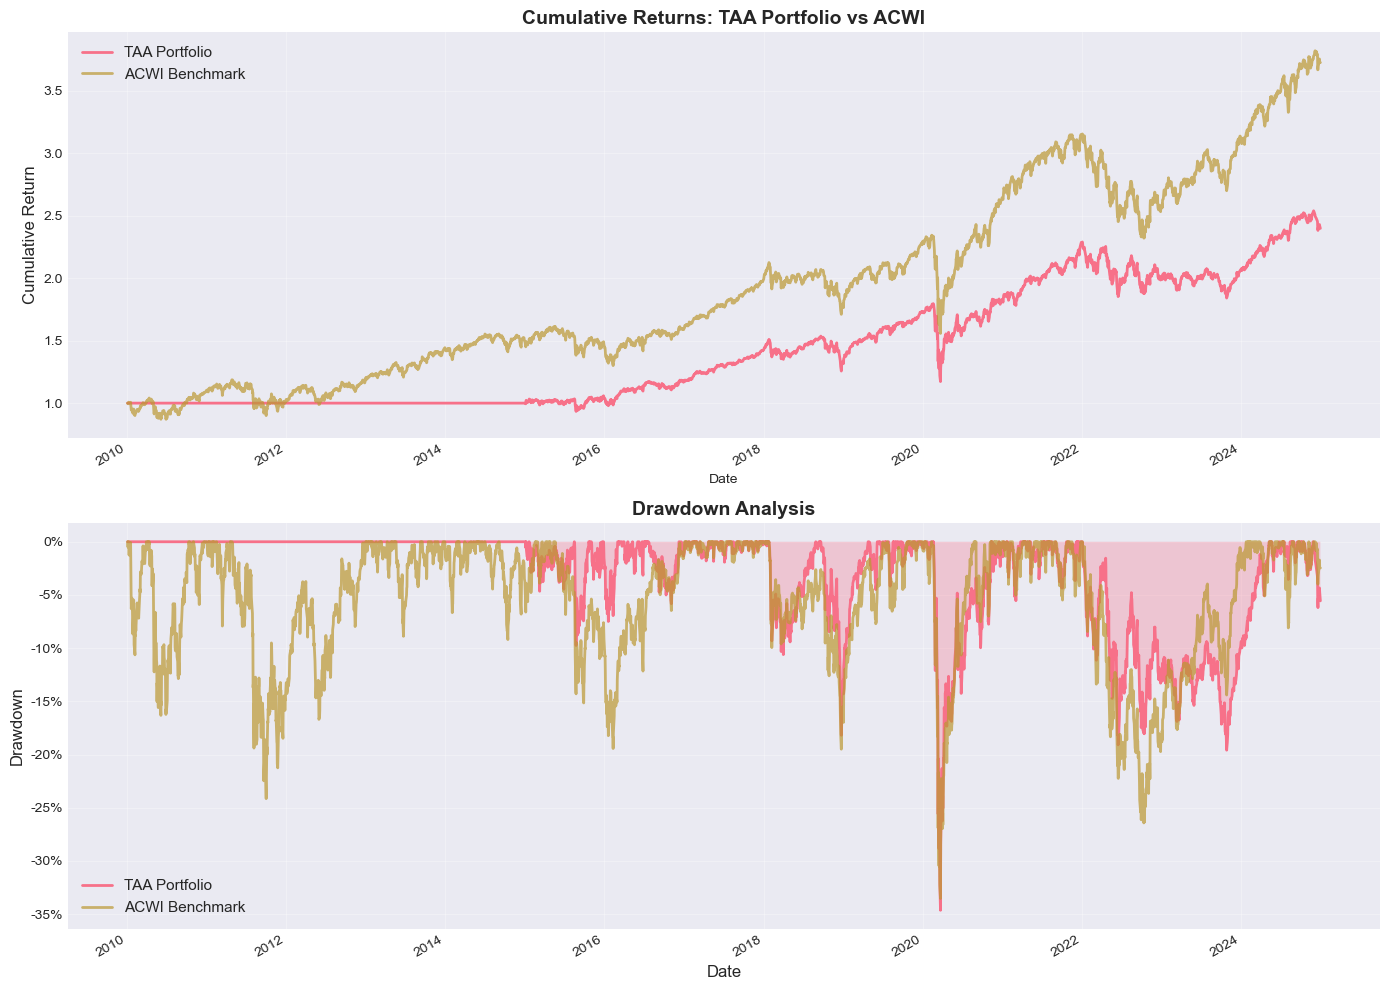

In [25]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Cumulative returns
ax1 = axes[0]
cumulative_returns.plot(ax=ax1, label='TAA Portfolio', linewidth=2)
benchmark_cumulative.plot(ax=ax1, label='ACWI Benchmark', linewidth=2, alpha=0.7)
ax1.set_title('Cumulative Returns: TAA Portfolio vs ACWI', fontsize=14, fontweight='bold')
ax1.set_ylabel('Cumulative Return', fontsize=12)
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)

# Drawdown
ax2 = axes[1]
portfolio_rolling_max = cumulative_returns.expanding().max()
portfolio_drawdown = (cumulative_returns - portfolio_rolling_max) / portfolio_rolling_max

benchmark_rolling_max = benchmark_cumulative.expanding().max()
benchmark_drawdown = (benchmark_cumulative - benchmark_rolling_max) / benchmark_rolling_max

portfolio_drawdown.plot(ax=ax2, label='TAA Portfolio', linewidth=2, color='C0')
benchmark_drawdown.plot(ax=ax2, label='ACWI Benchmark', linewidth=2, alpha=0.7, color='C1')
ax2.fill_between(portfolio_drawdown.index, portfolio_drawdown, 0, alpha=0.3)
ax2.set_title('Drawdown Analysis', fontsize=14, fontweight='bold')
ax2.set_ylabel('Drawdown', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.legend(loc='best', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

plt.tight_layout()
plt.show()

## 9. Rolling Sharpe Ratio

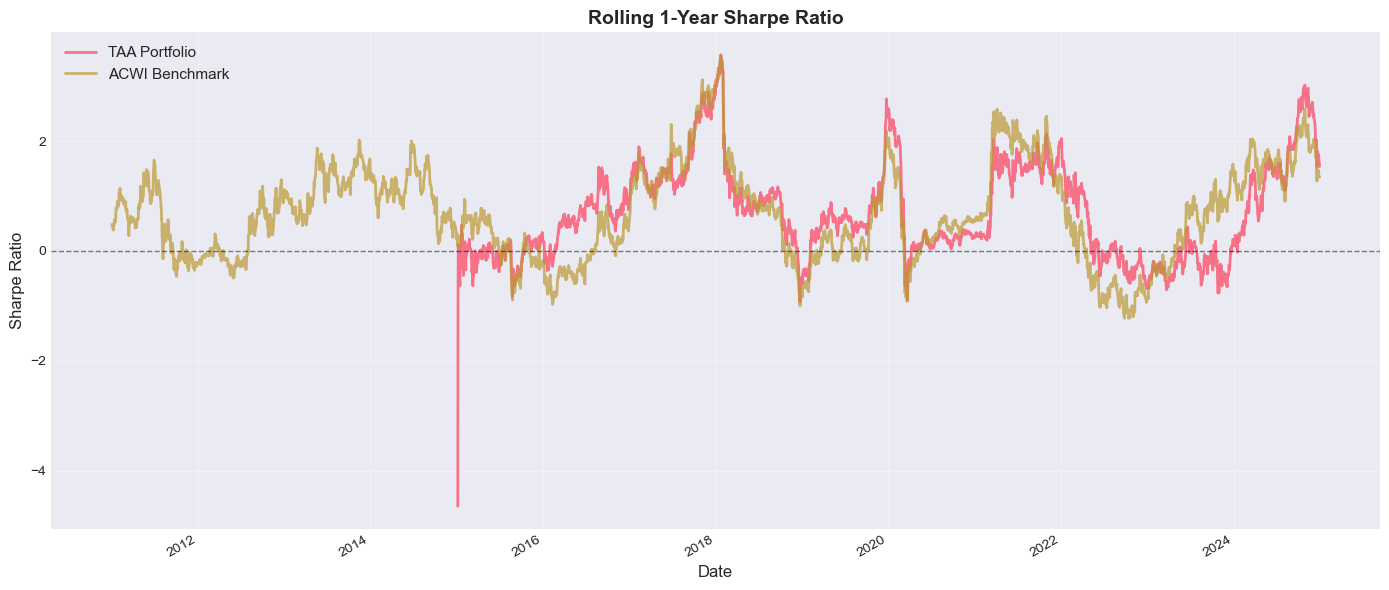

In [26]:
# Calculate rolling 252-day Sharpe
window = 252
portfolio_excess = portfolio_returns - 0.02 / 252
benchmark_excess = benchmark_returns - 0.02 / 252

portfolio_rolling_sharpe = (
    np.sqrt(252) * portfolio_excess.rolling(window).mean() / portfolio_returns.rolling(window).std()
)
benchmark_rolling_sharpe = (
    np.sqrt(252) * benchmark_excess.rolling(window).mean() / benchmark_returns.rolling(window).std()
)

fig, ax = plt.subplots(figsize=(14, 6))
portfolio_rolling_sharpe.plot(ax=ax, label='TAA Portfolio', linewidth=2)
benchmark_rolling_sharpe.plot(ax=ax, label='ACWI Benchmark', linewidth=2, alpha=0.7)
ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_title('Rolling 1-Year Sharpe Ratio', fontsize=14, fontweight='bold')
ax.set_ylabel('Sharpe Ratio', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Portfolio Weights Heatmap

/var/folders/nz/j4jbvftx68bd6h7_50gvnh180000gn/T/ipykernel_35989/2728112295.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_weights = weights_only.resample('M').last()


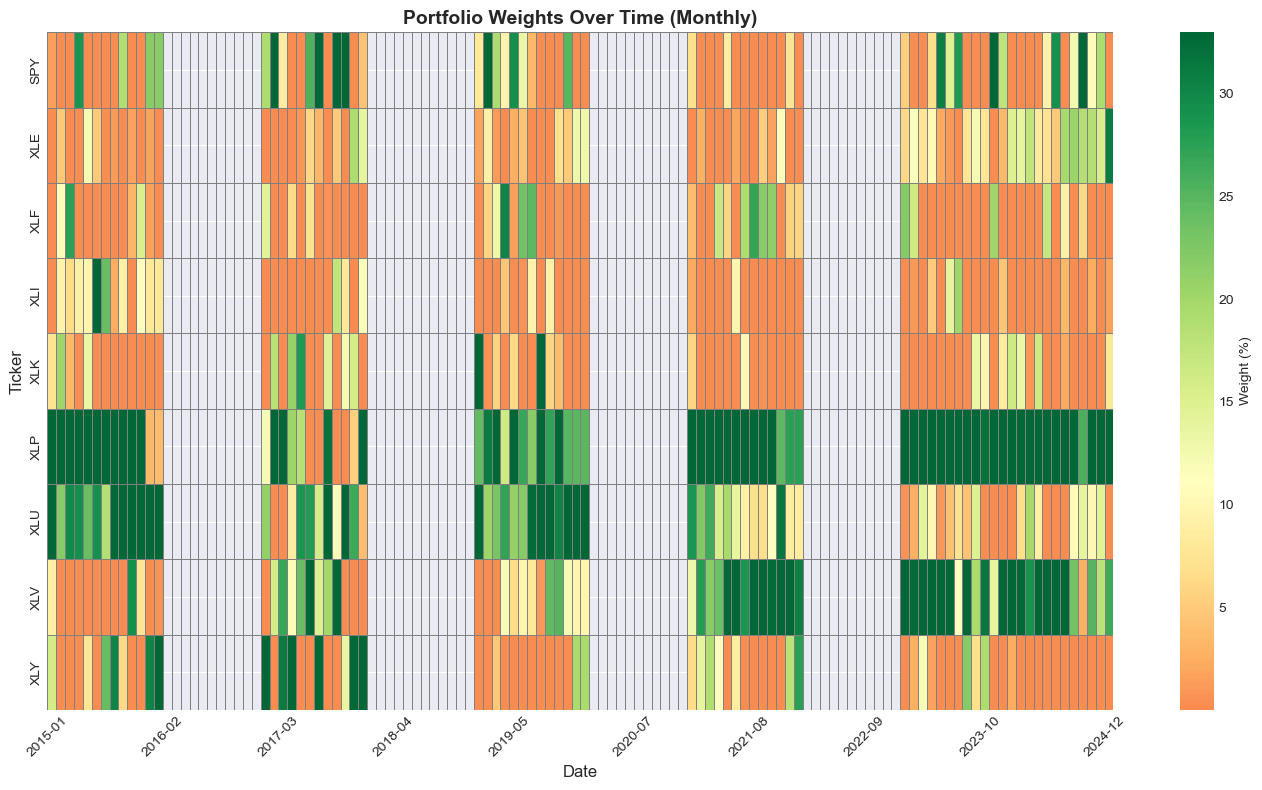

In [27]:
# Resample weights to monthly for cleaner visualization
monthly_weights = weights_only.resample('M').last()

fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(
    monthly_weights.T * 100,  # Convert to percentages
    cmap='RdYlGn',
    center=100/len(weight_cols),  # Equal weight as neutral
    cbar_kws={'label': 'Weight (%)'},
    ax=ax,
    linewidths=0.5,
    linecolor='gray'
)
ax.set_title('Portfolio Weights Over Time (Monthly)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Ticker', fontsize=12)

# Format x-axis to show fewer labels
n_ticks = 10
tick_positions = np.linspace(0, len(monthly_weights) - 1, n_ticks, dtype=int)
ax.set_xticks(tick_positions)
ax.set_xticklabels([monthly_weights.index[i].strftime('%Y-%m') for i in tick_positions], rotation=45)

plt.tight_layout()
plt.show()

## 11. Turnover Analysis

/var/folders/nz/j4jbvftx68bd6h7_50gvnh180000gn/T/ipykernel_35989/1017031119.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_turnover = weight_changes.resample('M').sum()


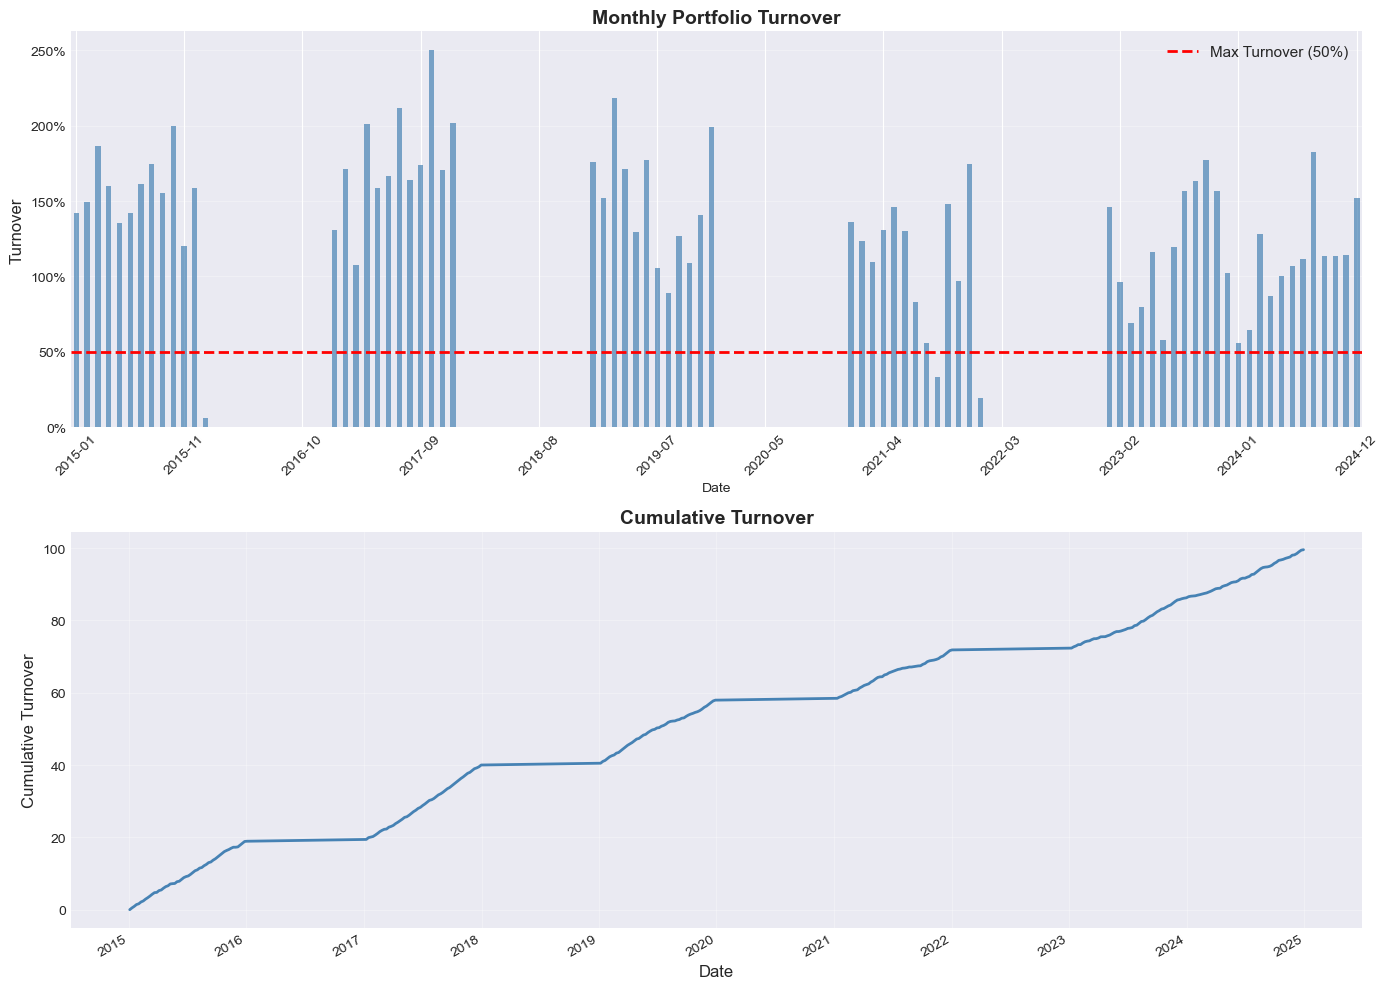


Average monthly turnover: 82.96%
Max monthly turnover: 250.00%
Total cumulative turnover: 99.55


In [28]:
# Calculate turnover from weight changes
weight_changes = weights_only.diff().abs().sum(axis=1)
monthly_turnover = weight_changes.resample('M').sum()

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Monthly turnover
ax1 = axes[0]
monthly_turnover.plot(kind='bar', ax=ax1, color='steelblue', alpha=0.7)
ax1.axhline(
    constraints.turnover.max_monthly, 
    color='red', 
    linestyle='--', 
    linewidth=2, 
    label=f'Max Turnover ({constraints.turnover.max_monthly*100:.0f}%)'
)
ax1.set_title('Monthly Portfolio Turnover', fontsize=14, fontweight='bold')
ax1.set_ylabel('Turnover', fontsize=12)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')

# Limit x-axis labels
n_labels = 12
label_indices = np.linspace(0, len(monthly_turnover) - 1, n_labels, dtype=int)
ax1.set_xticks(label_indices)
ax1.set_xticklabels([monthly_turnover.index[i].strftime('%Y-%m') for i in label_indices], rotation=45)

# Cumulative turnover
ax2 = axes[1]
cumulative_turnover = weight_changes.cumsum()
cumulative_turnover.plot(ax=ax2, linewidth=2, color='steelblue')
ax2.set_title('Cumulative Turnover', fontsize=14, fontweight='bold')
ax2.set_ylabel('Cumulative Turnover', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAverage monthly turnover: {monthly_turnover.mean()*100:.2f}%")
print(f"Max monthly turnover: {monthly_turnover.max()*100:.2f}%")
print(f"Total cumulative turnover: {cumulative_turnover.iloc[-1]:.2f}")

## 12. Tracking Error Analysis

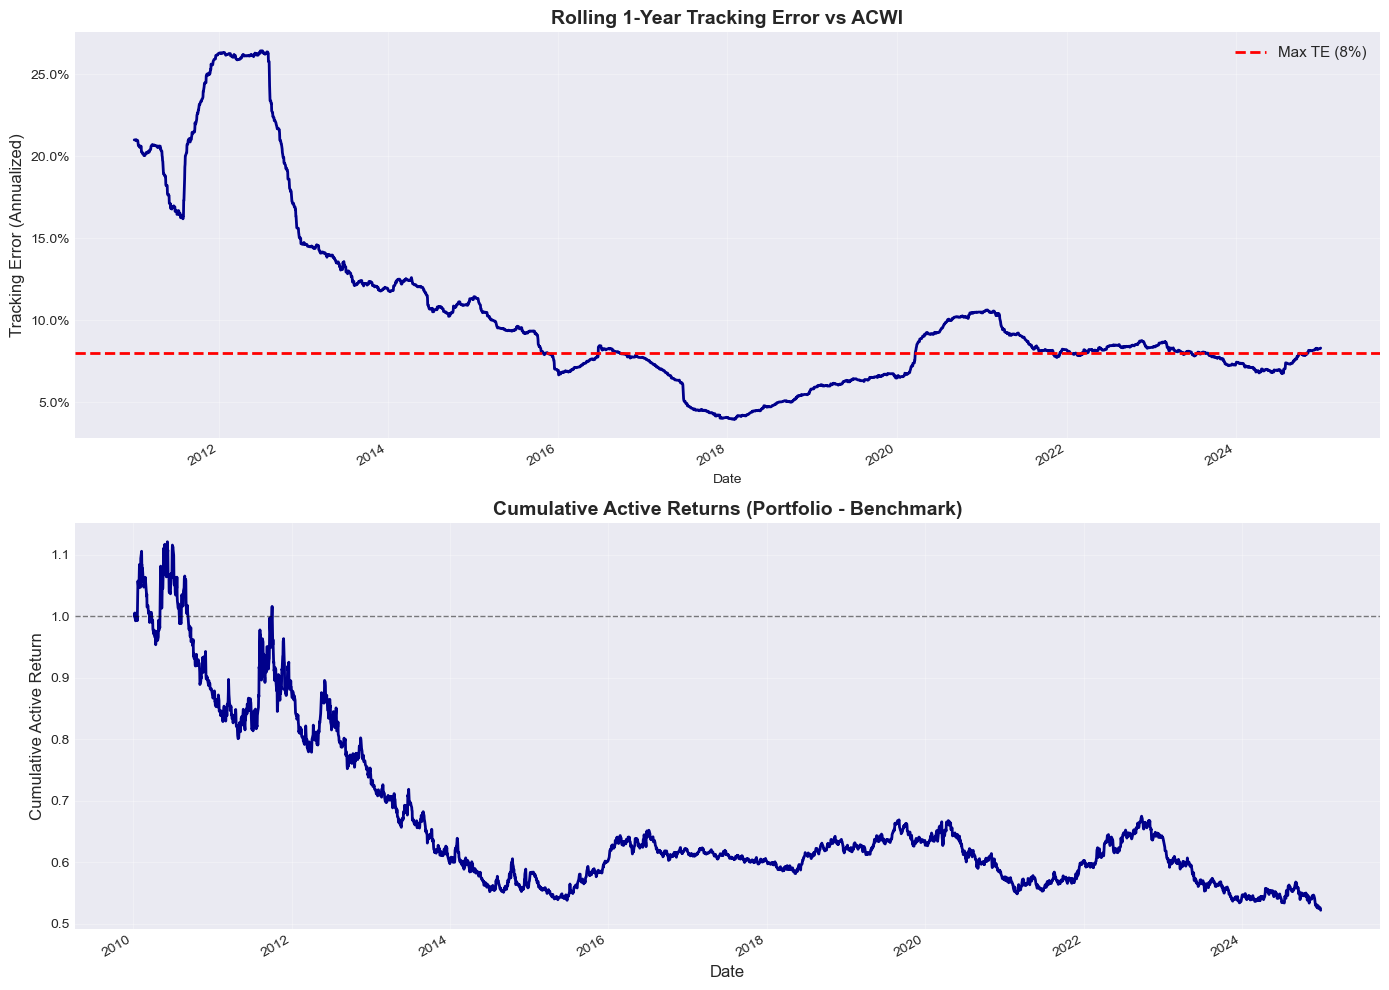


Realized Tracking Error: 12.05%
Information Ratio: -0.300
Alpha (annualized): -3.62%


In [29]:
# Calculate active returns
active_returns = portfolio_returns - benchmark_returns

# Rolling tracking error (252-day window)
rolling_te = active_returns.rolling(252).std() * np.sqrt(252)

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Rolling tracking error
ax1 = axes[0]
rolling_te.plot(ax=ax1, linewidth=2, color='darkblue')
ax1.axhline(
    constraints.tracking_error.max_te, 
    color='red', 
    linestyle='--', 
    linewidth=2, 
    label=f'Max TE ({constraints.tracking_error.max_te*100:.0f}%)'
)
ax1.set_title('Rolling 1-Year Tracking Error vs ACWI', fontsize=14, fontweight='bold')
ax1.set_ylabel('Tracking Error (Annualized)', fontsize=12)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.1f}%'))
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)

# Cumulative active returns
ax2 = axes[1]
cumulative_active = (1 + active_returns).cumprod()
cumulative_active.plot(ax=ax2, linewidth=2, color='darkblue')
ax2.axhline(1, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_title('Cumulative Active Returns (Portfolio - Benchmark)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Cumulative Active Return', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate realized tracking error
realized_te = active_returns.std() * np.sqrt(252)
information_ratio = (active_returns.mean() * 252) / realized_te

print(f"\nRealized Tracking Error: {realized_te*100:.2f}%")
print(f"Information Ratio: {information_ratio:.3f}")
print(f"Alpha (annualized): {active_returns.mean() * 252 * 100:.2f}%")

## 13. Transaction Cost Impact

In [30]:
# Debug: Check variables before calculating net returns
print("Debug info:")
print(f"weight_changes shape: {weight_changes.shape}")
print(f"weight_changes has NaN: {weight_changes.isna().any()}")
print(f"weight_changes first few:\n{weight_changes.head()}")
print(f"\ntc_rate: {tc_rate}")
print(f"\nturnover_costs shape: {(weight_changes * tc_rate).shape}")
print(f"turnover_costs has NaN: {(weight_changes * tc_rate).isna().any()}")
print(f"\nportfolio_returns shape: {portfolio_returns.shape}")
print(f"portfolio_returns index range: {portfolio_returns.index.min()} to {portfolio_returns.index.max()}")
print(f"weight_changes index range: {weight_changes.index.min()} to {weight_changes.index.max()}")
print(f"\nIndex alignment check:")
print(f"  Are indices equal? {portfolio_returns.index.equals(weight_changes.index)}")
if not portfolio_returns.index.equals(weight_changes.index):
    print(f"  portfolio_returns has {len(portfolio_returns)} dates")
    print(f"  weight_changes has {len(weight_changes)} dates")
    print(f"  Difference: {len(portfolio_returns) - len(weight_changes)}")

Debug info:
weight_changes shape: (314,)
weight_changes has NaN: False
weight_changes first few:
Date
2015-01-04    0.000000
2015-01-11    0.500000
2015-01-18    0.419945
2015-01-25    0.500000
2015-02-01    0.212650
dtype: float64

tc_rate: 0.0008

turnover_costs shape: (314,)
turnover_costs has NaN: False

portfolio_returns shape: (3772,)
portfolio_returns index range: 2010-01-05 00:00:00 to 2024-12-30 00:00:00
weight_changes index range: 2015-01-04 00:00:00 to 2024-12-29 00:00:00

Index alignment check:
  Are indices equal? False
  portfolio_returns has 3772 dates
  weight_changes has 314 dates
  Difference: 3458


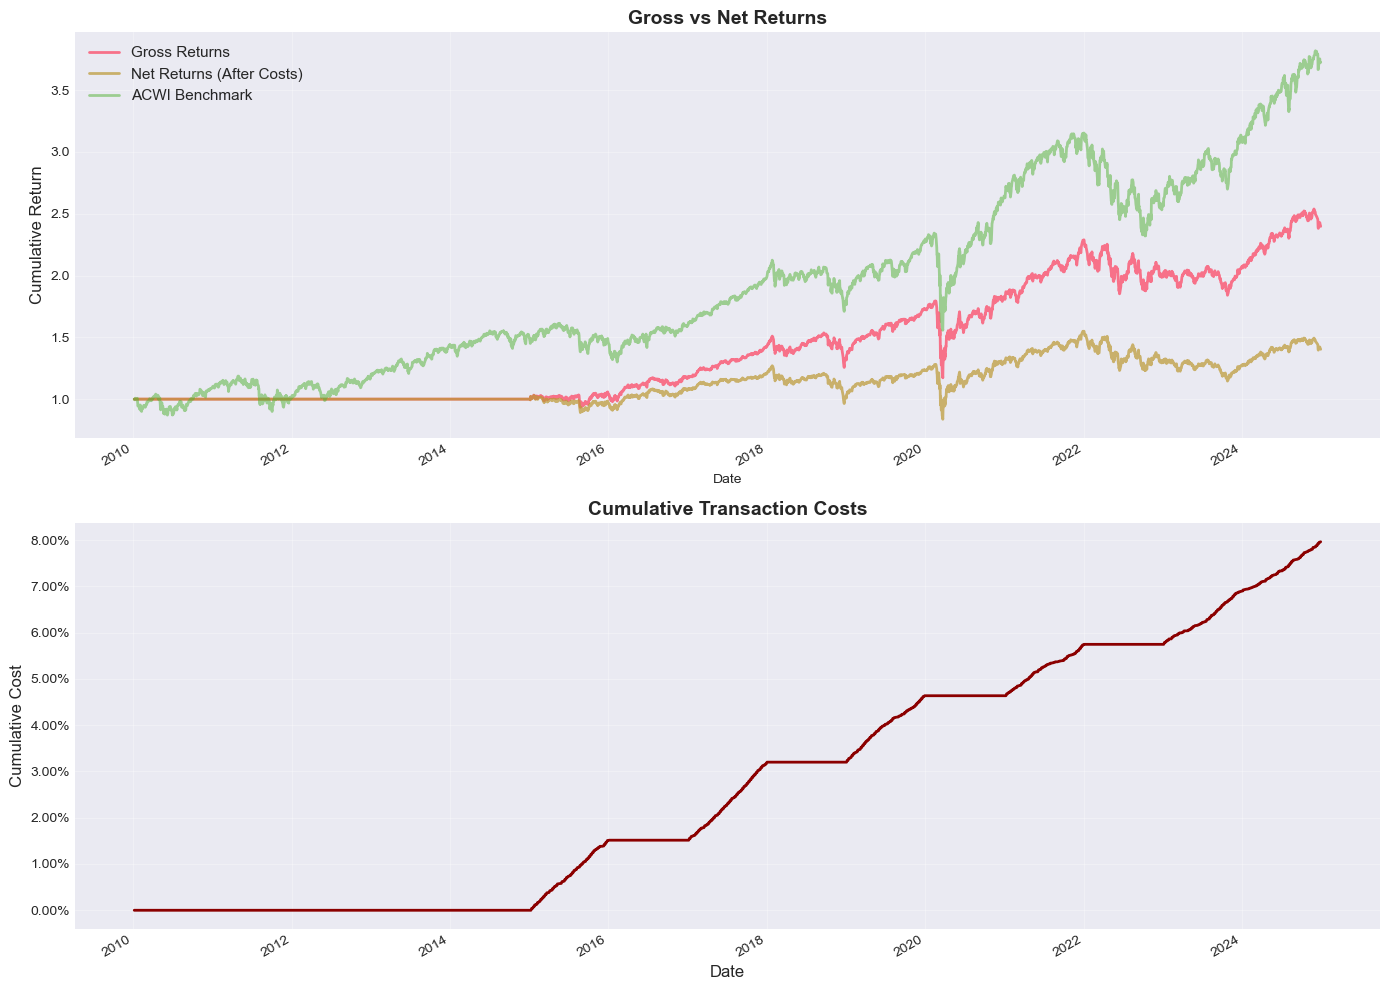


NET PERFORMANCE (After Transaction Costs)
                    Total Return   CAGR Volatility Sharpe Ratio Max Drawdown
Strategy                                                                    
TAA Portfolio            139.76%  6.01%     12.89%        0.363      -34.63%
TAA Portfolio (Net)       40.32%  2.29%     12.88%        0.085      -34.63%
ACWI Benchmark           272.45%  9.17%     17.33%        0.479      -33.53%

Total transaction costs: 7.96%
Annualized cost drag: 0.53%


In [31]:
# Calculate transaction costs
tc_bps = constraints.transaction_costs.commission_bps + constraints.transaction_costs.slippage_bps
tc_rate = tc_bps / 10000

# Turnover-based costs (weekly)
turnover_costs_weekly = weight_changes * tc_rate

# Align turnover costs with daily returns (forward-fill to daily frequency)
# Transaction costs are incurred on rebalance dates, then amortized daily
turnover_costs = turnover_costs_weekly.reindex(portfolio_returns.index, method='ffill').fillna(0)

# Net returns after costs
net_returns = portfolio_returns - turnover_costs
net_cumulative = (1 + net_returns).cumprod()

# Calculate cumulative costs for reporting (from weekly data)
cumulative_costs_weekly = turnover_costs_weekly.cumsum()
cumulative_costs = cumulative_costs_weekly.reindex(portfolio_returns.index, method='ffill').fillna(0)

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Gross vs Net returns
ax1 = axes[0]
cumulative_returns.plot(ax=ax1, label='Gross Returns', linewidth=2)
net_cumulative.plot(ax=ax1, label='Net Returns (After Costs)', linewidth=2, alpha=0.7)
benchmark_cumulative.plot(ax=ax1, label='ACWI Benchmark', linewidth=2, alpha=0.5)
ax1.set_title('Gross vs Net Returns', fontsize=14, fontweight='bold')
ax1.set_ylabel('Cumulative Return', fontsize=12)
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)

# Cumulative costs
ax2 = axes[1]
cumulative_costs.plot(ax=ax2, linewidth=2, color='darkred')
ax2.set_title('Cumulative Transaction Costs', fontsize=14, fontweight='bold')
ax2.set_ylabel('Cumulative Cost', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.2f}%'))
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate net metrics
net_metrics = calculate_metrics(net_returns, 'TAA Portfolio (Net)')
print("\n" + "="*80)
print("NET PERFORMANCE (After Transaction Costs)")
print("="*80)
net_comparison = pd.DataFrame([portfolio_metrics, net_metrics, benchmark_metrics]).set_index('Strategy')
print(net_comparison.to_string())
print("="*80)
print(f"\nTotal transaction costs: {cumulative_costs.iloc[-1]*100:.2f}%")
print(f"Annualized cost drag: {(cumulative_costs.iloc[-1] / ((net_returns.index[-1] - net_returns.index[0]).days / 365.25))*100:.2f}%")

## 14. Save Results

In [32]:
# Create results directory
results_dir = Path('../../data/taa/backtest_results')
results_dir.mkdir(parents=True, exist_ok=True)

# Save portfolio weights
portfolio_weights.to_csv(results_dir / 'portfolio_weights.csv')
print(f"Saved portfolio weights to {results_dir / 'portfolio_weights.csv'}")

# Save returns
returns_df = pd.DataFrame({
    'Portfolio_Gross': portfolio_returns,
    'Portfolio_Net': net_returns,
    'Benchmark': benchmark_returns,
    'Active': active_returns
})
returns_df.to_csv(results_dir / 'returns.csv')
print(f"Saved returns to {results_dir / 'returns.csv'}")

# Save metrics
metrics_df = pd.DataFrame([portfolio_metrics, net_metrics, benchmark_metrics]).set_index('Strategy')
metrics_df.to_csv(results_dir / 'performance_metrics.csv')
print(f"Saved metrics to {results_dir / 'performance_metrics.csv'}")

print("\n✅ Backtest complete! Results saved.")


Saved portfolio weights to ../../data/taa/backtest_results/portfolio_weights.csv
Saved returns to ../../data/taa/backtest_results/returns.csv
Saved metrics to ../../data/taa/backtest_results/performance_metrics.csv

✅ Backtest complete! Results saved.
